In [10]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

def load_dataset(input_dir, target_dir):
    input_image = load_image(input_dir)
    target_image = load_image(target_dir)

    if input_image is None or target_image is None:
        raise ValueError(f"Invalid file paths: Check that `{input_dir}` and `{target_dir}` contain valid image files.")

    input_image = tf.expand_dims(input_image, axis=0)
    target_image = tf.expand_dims(target_image, axis=0)
    return tf.data.Dataset.from_tensor_slices((input_image, target_image))


In [11]:
from tensorflow.keras import layers

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    ]

    up_stack = [
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'),
    ]

    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = build_generator()

In [12]:
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])
    targets = layers.Input(shape=[256, 256, 3])

    x = layers.Concatenate()([inputs, targets])

    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model(inputs=[inputs, targets], outputs=x)

discriminator = build_discriminator()


In [13]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for input_image, target in dataset:
            gen_loss, disc_loss = train_step(input_image, target)

        print(f"Epoch {epoch+1}/{epochs}: Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}")


In [15]:
def generate_images(model, test_input, target):
    test_input = tf.expand_dims(test_input, axis=0)
    target = tf.expand_dims(target, axis=0)

    prediction = model(test_input, training=False)


    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow((display_list[i].numpy() + 1) / 2)
        plt.axis('off')
    plt.show()


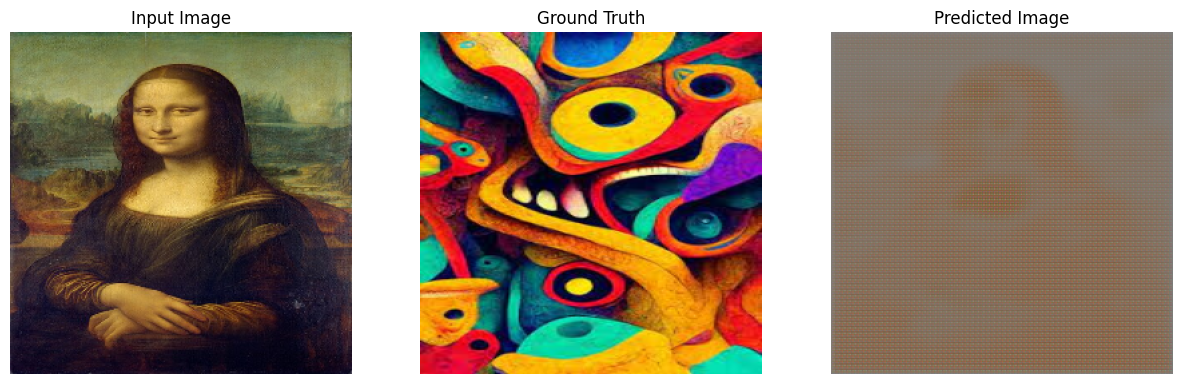

In [16]:
for input_image, target in dataset.take(1):
    generate_images(generator, input_image, target)